# Imports

In [1]:
import pandas as pd
import os
import random
from fuzzywuzzy import fuzz
from fuzzywuzzy import process
import matplotlib.pyplot as plt
import seaborn as sns


# Create Function to Concat Datasets


This function assists in managing the numerous small data chunks received.

In [2]:
def concat_csvs_in_directory(folder_path, output_path):
    """
    Concatenates all CSV files in the specified directory and saves them to a single output CSV file.

    Args:
    folder_path (str): Path to the directory containing the CSV files.
    output_path (str): Path where the concatenated CSV should be saved.
    """
    dataframes = []
    # Loop through all files in the folder
    for file_name in os.listdir(folder_path):
        # Check if the file is a CSV
        if file_name.endswith('.csv'):
            # Construct full file path
            file_path = os.path.join(folder_path, file_name)
            # Read the CSV file and append to the list
            df = pd.read_csv(file_path)
            dataframes.append(df)

    # Concatenate all dataframes in the list
    combined_df = pd.concat(dataframes, ignore_index=True)

    # Save the combined dataframe to a new CSV file
    combined_df.to_csv(output_path, index=False)

    print(f"Combined CSV saved to {output_path}")


# Fuzzy Match Implementation

I believe the messy nature of the data necessitated the implementation of fuzzy matching due to the high volume of data entry errors.

In [3]:
def is_purdue(university_name, threshold=90):
    """
    Check if the university name matches "Purdue" with a similarity above the given threshold.
    
    Args:
    - university_name (str): The university name to check.
    - threshold (int): The similarity threshold for a match.
    
    Returns:
    - bool: True if the similarity is above the threshold, False otherwise.
    """
    similarity = fuzz.partial_ratio("Purdue", university_name)
    return similarity >= threshold

df = pd.read_csv(r'C:\Users\thats\Desktop\Revelio\Individual_data\202403\individual_user_education\combined_csv.csv')

df.head()
df = df.dropna(subset=['university_name'])

df_purdue = df[df['university_name'].apply(lambda x: is_purdue(x))]

print(df_purdue.head())

         user_id                                     university_raw  \
186    465783961                        Purdue University Northwest   
679     43690696  Indiana University-Purdue University at Indian...   
908   2010911373                           Purdue University Global   
1544   125393177                                  Purdue University   
1654   472792325                                  Purdue University   

                                        university_name  education_number  \
186                         Purdue University Northwest                 2   
679   Indiana University Purdue University Indianapolis                 1   
908                            Purdue University Global                 2   
1544                                  Purdue University                 2   
1654                                  Purdue University                 2   

       startdate     enddate    degree        field  \
186   2014-01-01  2015-01-31     empty  Engineering   


# Generate List of unique purdue ids

We wanted to generate a list of unique Purdue ID's which will become the foundation of our future analysis.

In [4]:
unique_user_ids = df_purdue['user_id'].unique()
unique_user_ids.shape

(14265,)

This code filters a DataFrame to include only the complete education profiles for unique user IDs, then checks and prints the number of unique individuals and total education records. It removes duplicate records, calculates the change in the number of observations due to duplicate deletion, and exports the cleaned data to a CSV file.

In [5]:
# Filter the original DataFrame for complete education profiles of the unique IDs
complete_education_profiles = df[df['user_id'].isin(unique_user_ids)]

# Check the number of unique individuals and total education records in the filtered dataset
                                        
print(f"Number of unique individuals: {complete_education_profiles['user_id'].nunique()}")
print(f"Total education records: {len(complete_education_profiles)}")

values = complete_education_profiles.shape
complete_profiles = complete_education_profiles.drop_duplicates()
values_2 = complete_profiles.shape

print("Change in observations due to duplicate deletion is ", values_2[0] - values[0])

# Optionally, export this data to a CSV file for further analysis or sharing
complete_profiles.to_csv('complete_education_profiles.csv', index=False)


Number of unique individuals: 14265
Total education records: 59322
Change in observations due to duplicate deletion is  -29661


In [6]:
complete_education_profiles.shape

(59322, 14)

In [7]:
complete_education_profiles['university_name'].value_counts()

university_name
Purdue University                                    13518
Indiana University Purdue University Indianapolis     7242
Purdue University Global                              5950
Purdue University Northwest                           5336
Purdue University Fort Wayne                          3686
                                                     ...  
south knox high school                                   2
wilson high school                                       2
sri jayachamarajendra college of engg mysore             2
Faulkner University                                      2
University of North Carolina Greensboro                  2
Name: count, Length: 3719, dtype: int64

This code filters the DataFrame to handle edge cases by ensuring 'university_name' has at least 4 characters, converts 'user_id' to integers, and exports the filtered data to a CSV file.

In [8]:
# This line handles several edge cases that were returned through fuzzy match
df_filtered = complete_education_profiles[complete_education_profiles['university_name'].str.len() >= 4] 

# Ensure that all user_id's are set as integers
df_filtered['user_id'] = df_filtered['user_id'].astype(int)

# Export to a CSV for analysis
df_filtered.to_csv('complete_education_profiles_filtered.csv')

<ipython-input-8-511d55cf9308>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['user_id'] = df_filtered['user_id'].astype(int)


# Merge Purdue Dataset with the Skills Dataset


This code reads a CSV file into a DataFrame, sorts it by 'user_id' in ascending order, resets the index, and drops the 'Unnamed: 0' column.

In [9]:
temp_df = pd.read_csv('complete_education_profiles_filtered.csv')
temp_sorted = temp_df.sort_values(by='user_id', ascending=True)
temp_sorted = temp_sorted.reset_index(drop=True)
temp_sorted = temp_sorted.drop(columns=['Unnamed: 0'])

In [10]:
# drop duplicates on user_id and keep track of how many obs were lost
# It was at this point I realized that all the data originally given was duplicated once
values = temp_sorted.shape
purdue_unique = temp_sorted.drop_duplicates()
values_2 = purdue_unique.shape

print("Change in observations due to duplicate deletion is ", values_2[0] - values[0])
purdue_unique.shape

purdue_unique.to_csv('Purdue_unique.csv')

Change in observations due to duplicate deletion is  -29639


# Merge Small Chunks into One

The following code cells are commented out because they are no longer needed. The purpose of these two blocks is to combine all the smaller datasets from each data subset into one.

In [11]:
"""
# create gigafile for each data chunk
concat_csvs_in_directory(r'C:\Users\thats\Desktop\Revelio\Individual_data\202403\individual_position',

r'C:\Users\thats\Desktop\Revelio\Individual_data\202403\individual_position\combined_position.csv')

"""

SyntaxError: (unicode error) 'unicodeescape' codec can't decode bytes in position 68-69: truncated \UXXXXXXXX escape (<ipython-input-11-770b68c83e20>, line 1)

In [ ]:
"""
concat_csvs_in_directory(r'C:\Users\thats\Desktop\Revelio\Individual_data\202403\individual_user',
                         r'C:\Users\thats\Desktop\Revelio\Individual_data\202403\individual_user\combined_user.csv')
concat_csvs_in_directory(r'C:\Users\thats\Desktop\Revelio\Individual_data\202403\individual_user_certifications',
                         r'C:\Users\thats\Desktop\Revelio\Individual_data\202403\individual_user_certifications\combined_certifications.csv')
concat_csvs_in_directory(r'C:\Users\thats\Desktop\Revelio\Individual_data\202403\individual_user_skill',
                         r'C:\Users\thats\Desktop\Revelio\Individual_data\202403\individual_user_skill\combined_skill.csv')

"""

# Merge the Individual User Data to get the Linkedin Profile Link

In [12]:
df_individual_user = pd.read_csv(r'C:\Users\thats\Desktop\Revelio\Individual_data\202403\individual_user\combined_user.csv')
df_individual_user['user_id'] = df_individual_user['user_id'].astype(int)

final_df = df_filtered.merge(df_individual_user, on= 'user_id', how = 'left')

## The next step is to check for any missing values 

This code initializes a dictionary to store the count of missing values per column, iterates through each column in the DataFrame to count the missing values, stores these counts in the dictionary, and then prints the number of missing values for each column.

In [13]:
# Initialize a dictionary to store the count of missing values per column
missing_values = {}

# Iterate through each column in the DataFrame
for column in final_df.columns:
    # Count the number of missing values in the column
    missing_count = final_df[column].isna().sum()
    # Store the count in the dictionary
    missing_values[column] = missing_count

# Print the dictionary to see the missing values count per column
for column, count in missing_values.items():
    print(f"Missing values in '{column}': {count}")


Missing values in 'user_id': 0
Missing values in 'university_raw': 6
Missing values in 'university_name': 0
Missing values in 'education_number': 0
Missing values in 'startdate': 16446
Missing values in 'enddate': 16794
Missing values in 'degree': 0
Missing values in 'field': 0
Missing values in 'degree_raw': 9530
Missing values in 'field_raw': 9840
Missing values in 'world_rank': 43732
Missing values in 'us_rank': 33664
Missing values in 'university_country': 27702
Missing values in 'university_location': 22082
Missing values in 'firstname': 32
Missing values in 'lastname': 226
Missing values in 'fullname': 0
Missing values in 'f_prob': 0
Missing values in 'm_prob': 0
Missing values in 'white_prob': 0
Missing values in 'black_prob': 0
Missing values in 'api_prob': 0
Missing values in 'hispanic_prob': 0
Missing values in 'native_prob': 0
Missing values in 'multiple_prob': 0
Missing values in 'prestige': 0
Missing values in 'highest_degree': 0
Missing values in 'sex_predicted': 0
Missin

In [14]:
final_df.shape

(59278, 36)

In [15]:
final_df = final_df.drop_duplicates()

This code defines a list of university names of interest, filters the DataFrame for Bachelor's degrees in Accounting from these universities, identifies the unique user IDs of students meeting these criteria, and prints the number of these unique user IDs.

In [16]:
# Define the universities we are interested in at this point in time
university_names = [
    'Purdue University',
    'Purdue University Krannert School Of Management',
    'Purdue University Daniels School Of Business',
    'Purdue University - Krannert School of Management',
    
]

# Filter for Bachelor's degree at Purdue University majoring in Accounting
df_accounting_purdue_temp = final_df[
    (final_df['degree'] == 'Bachelor') &  # Filter by degree type
    (final_df['university_name'].isin(university_names)) &  # University contains 'Purdue'
    (final_df['field'].str.contains('Accounting', case=False, na=False))  # Field contains 'Accounting'
]

purdue_accounting_undergrads = df_accounting_purdue_temp['user_id'].unique()

print(len(purdue_accounting_undergrads))

1553


### At this point, we have a list of all unique purdue undergrads that graduated with an accounting degree

In [17]:
# conver a list to a 1-column dataset
df_purdue_accounting_undergrads = pd.DataFrame(purdue_accounting_undergrads, columns=['user_id'])
df_purdue_accounting_undergrads

,user_id
0,125393177
1,400649920
2,129155434
3,980998042
4,537443530
...,...
1548,582533121
1549,667479403
1550,528715669
1551,389112648


# Get the Start and End Date of Their Tenure at Purdue

In [18]:
temp_df_users = pd.read_csv(r'C:\Users\thats\Desktop\Revelio\Individual_data\202403\individual_user\combined_user.csv')

In [19]:
# The next step is to get the start and end date as well as the name of everyone on this list
df_purdue_accounting_undergrads_names = pd.merge(df_purdue_accounting_undergrads, 
                                                 temp_df_users[['firstname','lastname','user_id']],on='user_id',how='left')

In [20]:
df_purdue_accounting_undergrads_names['user_id'].value_counts() # Check that there are no duplicates

user_id
125393177    1
533164213    1
337176965    1
126461328    1
453662262    1
            ..
10878780     1
327482471    1
538364854    1
396601299    1
222513944    1
Name: count, Length: 1553, dtype: int64

This code loads the education dataset from a CSV file, filters it to include only records that match specific criteria (user IDs in a specified list, specific university names, Bachelor's degrees, and Accounting field), removes duplicate records, and displays the shape of the filtered DataFrame.

In [21]:
#prep the education dataset to be merged
# Load the education dataset
temp_df_education = pd.read_csv(r"C:\Users\thats\Desktop\Revelio\Individual_data\202403\individual_user_education\combined_csv.csv")

# Filter the DataFrame to include only specific criteria
filtered_education = temp_df_education[
    (temp_df_education['user_id'].isin(df_purdue_accounting_undergrads['user_id'])) &  # Ensure you reference the column correctly if it's a DataFrame
    (temp_df_education['university_name'].isin(university_names)) &
    (temp_df_education['degree'].str.contains('Bachelor', case=False, na=False)) &
    (temp_df_education['field'].str.contains('Accounting', case=False, na=False))# Check if university name is in the list of specified names
]

# Display the first few rows of the filtered DataFrame to verify
filtered_education.drop_duplicates(inplace=True)
filtered_education.shape

<ipython-input-21-f1c2116bf09e>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_education.drop_duplicates(inplace=True)


(1578, 14)

In [22]:
# next, add the start and end date of each student's tenure at purdue
df_purdue_accounting_undergrads_names_date = df_purdue_accounting_undergrads_names.merge(filtered_education[['startdate','enddate','user_id']],on='user_id',how='left')
df_purdue_accounting_undergrads_names_date.drop_duplicates(inplace=True)
df_purdue_accounting_undergrads_names_date.to_csv('purdue_accounting_undergrads_names_date.csv')

In [23]:
df_purdue_accounting_undergrads_names_date['user_id'].value_counts()

user_id
220653150     2
368480770     2
508215412     2
435317016     2
441426687     2
             ..
98510948      1
2034974520    1
868686414     1
10878780      1
222513944     1
Name: count, Length: 1553, dtype: int64

In [24]:
import pandas as pd

# Assuming 'df' is your DataFrame and is already loaded.
# Example loading DataFrame if needed:
# df = pd.read_csv('path_to_your_file.csv')

# List of user_ids to remove
user_ids_to_remove = [441426687, 508215412, 231858506, 356317378]

# Filter the DataFrame to exclude rows where user_id is in the list of user_ids_to_remove

duplicates = df_purdue_accounting_undergrads_names_date.duplicated(subset=['user_id'], keep = False)

duplicate_rows = df_purdue_accounting_undergrads_names_date[duplicates]

# Display the cleaned DataFrame to verify rows are dropped
# Optionally, save the cleaned DataFrame to a new CSV file
# cleaned_df.to_csv('cleaned_data.csv', index=False)


In [25]:
# The duplicate records were not dropping from the dataset, so I eliminated these rows manually.
# for user_id no. 12972347 there seemed to be a conflict between the universtiy raw and university name for both indicies so I dropped both

In [26]:
index_to_drop = [71, 171, 206, 237, 422, 619, 620,655,1179]
df_purdue_accounting_undergrads_names_date = df_purdue_accounting_undergrads_names_date.drop(index_to_drop)


# Check if the student went on to get a master's degree in Accounting

In [27]:
# Filter the DataFrame to include only specific criteria
filtered_education = temp_df_education[
    (temp_df_education['user_id'].isin(df_purdue_accounting_undergrads_names_date['user_id'])) &  # Ensure you reference the column correctly if it's a DataFrame
    (temp_df_education['degree'].str.contains('MBA|Master', case=False, na=False)) &
    (temp_df_education['field'].str.contains('Accounting', case=False, na=False))# Check if university name is in the list of specified names
]
filtered_education.drop_duplicates(inplace=True)


<ipython-input-27-5274dbb779bf>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_education.drop_duplicates(inplace=True)


# Set students who got a master's degree in accounting to a 1 in the 'Master' column

In [28]:
filtered_education['Master'] = 1

<ipython-input-28-02c567d9ff0a>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_education['Master'] = 1


In [29]:
filtered_education = filtered_education[['user_id','Master']]
filtered_education

,user_id,Master
47619,459187572,1
53217,374582846,1
68020,679869631,1
70944,585433982,1
96391,569815254,1
...,...,...
5045152,584922206,1
5072858,10518076,1
5076707,167703224,1
5145232,149266536,1


Merge back into the other dataset from before.

In [30]:
df_purdue_accounting_undergrads_names_date_master = df_purdue_accounting_undergrads_names_date.merge(filtered_education, on='user_id',how='left')

#Fill all of the Nan's with 0 

df_purdue_accounting_undergrads_names_date_master['Master'] = df_purdue_accounting_undergrads_names_date_master['Master'].fillna(0)

In [31]:
df_purdue_accounting_undergrads_names_date_master.columns

Index(['user_id', 'firstname', 'lastname', 'startdate', 'enddate', 'Master'], dtype='object')

# Who went on to get a CPA?

In [32]:
# prep the certifications dataset to be merged
# Load the certification dataset
temp_df_cert = pd.read_csv(r"C:\Users\thats\Desktop\Revelio\Individual_data\202403\individual_user_certifications\combined_certifications.csv")

In [33]:
# Crate list of possible ways to say CPA
cpa_list = ['Certified Public Accountant',
           'CPA',
           'Certified Public Accountant (CPA)']
temp_df_cert['cert_name'].value_counts()


cert_name
Certified Public Accountant                                                                                        107102
CPA                                                                                                                 34445
Certified Public Accountant (CPA)                                                                                   21441
Notary Public                                                                                                        8432
Series 7                                                                                                             4365
                                                                                                                    ...  
Accounting for a Company's Stock and Dividend Transactions Alteryx Designer Core Certification                          1
National Payroll Certification                                                                                          1
K-Laser Advanc

In [34]:
# Filter the DataFrame to include only specific criteria
filtered_certification = temp_df_cert[
    (temp_df_cert['user_id'].isin(df_purdue_accounting_undergrads_names_date_master['user_id'])) &  # Ensure you reference the correct DataFrame
    (temp_df_cert['cert_name'].isin(cpa_list))
]

# Add a flag to everyone that got a CPA
filtered_certification.drop_duplicates(inplace=True)
filtered_certification['CPA'] = 1
filtered_certification = filtered_certification[['user_id','CPA']]
filtered_certification

<ipython-input-34-431b9634f23d>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_certification.drop_duplicates(inplace=True)
<ipython-input-34-431b9634f23d>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_certification['CPA'] = 1


,user_id,CPA
22882,688008628,1
23643,471794319,1
24889,157847153,1
28388,95417987,1
30083,648846038,1
...,...,...
1271984,165226597,1
1274388,844930325,1
1274389,844930325,1
1279933,418784259,1


In [36]:
df_purdue_accounting_undergrads_names_date_master_cpa = df_purdue_accounting_undergrads_names_date_master.merge(filtered_certification, on='user_id',how='left')

#Fill all of the Nan's with 0 

df_purdue_accounting_undergrads_names_date_master_cpa['CPA'] = df_purdue_accounting_undergrads_names_date_master_cpa['CPA'].fillna(0)

# Statistics

In [38]:

# Calculate percentage of students who got a CPA
cpa_percentage = df_purdue_accounting_undergrads_names_date_master_cpa['CPA'].mean() * 100
print(f"Percentage of students who got a CPA: {cpa_percentage:.2f}%")


Percentage of students who got a CPA: 8.11%


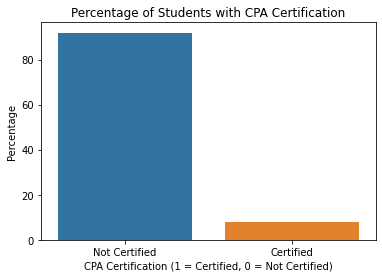

In [40]:

# Count the occurrences of each category
cpa_counts = df_purdue_accounting_undergrads_names_date_master_cpa['CPA'].value_counts(normalize=True) * 100

# Create a bar plot
sns.barplot(x=cpa_counts.index, y=cpa_counts.values)
plt.title('Percentage of Students with CPA Certification')
plt.xlabel('CPA Certification (1 = Certified, 0 = Not Certified)')
plt.ylabel('Percentage')
plt.xticks([0, 1], ['Not Certified', 'Certified'])  # Rename x-ticks for clarity
plt.show()


In [41]:
# Group by 'degree_type' and 'CPA', then calculate percentage
cpa_grouped = df_purdue_accounting_undergrads_names_date_master_cpa.groupby('Master')['CPA'].value_counts(normalize=True).mul(100).unstack()


<Figure size 1440x864 with 0 Axes>

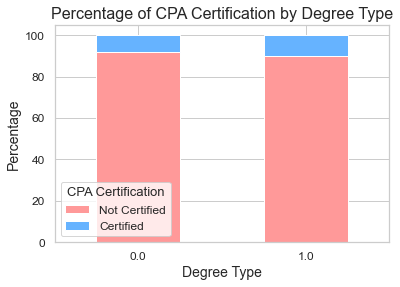

In [46]:
# Set the aesthetic style of the plots
sns.set(style="whitegrid")

# Increase the default figure size
plt.figure(figsize=(20, 12))  # Width, height in inches

# Example Data Preparation (assuming the dataframe is ready)
# cpa_grouped = df_purdue_accounting_undergrads_names_date_master_cpa.groupby('degree_type')['CPA'].value_counts(normalize=True).mul(100).unstack()

# Plotting the data
ax = cpa_grouped.plot(kind='bar', stacked=True, color=['#ff9999','#66b3ff'])  # Choose colors for visual distinction

# Title and labels
plt.title('Percentage of CPA Certification by Degree Type', fontsize=16)
plt.xlabel('Degree Type', fontsize=14)
plt.ylabel('Percentage', fontsize=14)
plt.xticks(rotation=0, fontsize=12)  # Keep the labels on the x-axis readable
plt.yticks(fontsize=12)

# Legend settings
plt.legend(title='CPA Certification', labels=['Not Certified', 'Certified'], fontsize=12, title_fontsize=13)

# Adding a grid for better readability of the plot
plt.grid(True)

# Show plot
plt.show()
